# **SENTIMENT ANALYSIS OF SXSW TECH TWEETS**
## Summary
This notebook builds an end-to-end NLP pipeline to classify the sentiment of tweets about Apple and Google products during the 2011 SXSW conference. The business goal is to help a marketing or product team monitor public reaction, highlighting positive engagement and surfacing negative feedback early, using supervised learning on labeled social media text. The dataset is well-suited because it contains real tweets (hashtags, mentions, links) and crowdsourced sentiment labels.

After loading the data, we check quality issues (missing values and duplicates) and apply an imputation step that recovers some missing product targets by matching brand keywords in tweet text. We then perform text preparation tailored to tweets: lowercasing, removing URLs and @mentions, stripping punctuation/numbers, removing English stopwords, and lemmatizing with NLTK. Cleaned text is converted into numerical features with TF-IDF, while sentiment labels are encoded with scikit-learn’s `LabelEncoder`.

For modeling, we begin with a baseline (TF-IDF + Multinomial Naive Bayes) and iterate to ensemble methods (Random Forest and XGBoost). To avoid leakage during tuning, we use a train/validation/test strategy and `GridSearchCV` to select hyperparameters. Performance is assessed with precision, recall, and F1-scores plus confusion matrices, emphasizing the impact of class imbalance. We also add interpretability through Random Forest feature importance and inspect a sample of misclassified tweets to understand error modes (e.g., ambiguity or sarcasm). Finally, we save the chosen model pipeline and label encoder for reproducible scoring of new tweets.


## NOTEBOOK WORKFLOW
This notebook follows the CRISP-DM workflow:

1. **Business Understanding** – define the stakeholder goal and success criteria  
2. **Data Understanding** – load the dataset and inspect labels/distributions  
3. **Data Preparation** – clean tweets, engineer/encode features, and prepare splits  
4. **Modeling** – establish a baseline, iterate on stronger models, and tune hyperparameters  
5. **Evaluation** – compare models using appropriate metrics and interpret results  
6. **Deployment** – save the final model artifacts and describe how they would be used in practice  

The steps are iterative: evaluation results can send us back to preparation or modeling for another improvement cycle.

## 1. Business Understanding
At large events like **SXSW**, brands are mentioned thousands of times on social media. Manually reading every tweet is slow and inconsistent, so stakeholders (marketing, product, and community teams) need an automated way to summarize public sentiment in near real time.

**Business problem:** given a tweet about an Apple or Google product, predict whether the sentiment is *Positive*, *Negative*, or *Neutral* (and optionally a simpler *Positive vs Negative* version). Accurate sentiment classification can support campaign measurement, rapid issue escalation, and post-event reporting.

## 2. Data Understanding
**Dataset:** Brands and Product Emotions (CrowdFlower) - tweets collected during the 2011 SXSW conference and labeled with sentiment.

In the next cells, we load the data, standardize column names, and check quality issues (missing values, duplicates, and label distribution).


In [1]:
# IMPORTING ALL THE LIBRARIES REQUIRED 

import pandas as pd              # dataframes
import numpy as np               # arrays
import re                        # regex
import nltk                      # NLP tools
from nltk.corpus import stopwords        # common words
from nltk.stem import WordNetLemmatizer  # lemmatizer
import matplotlib.pyplot as plt  # plotting
import seaborn as sns            # styled plots
import warnings                  # warnings
warnings.filterwarnings('ignore') # hide warnings
%matplotlib inline               
sns.set_theme(style="whitegrid") # plot theme
%pip install wordcloud           
from wordcloud import WordCloud  # word clouds
import matplotlib.pyplot as plt  # plotting
from sklearn.model_selection import train_test_split  # split data
from sklearn.preprocessing import LabelEncoder        # encode labels
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.pipeline import Pipeline                # ML pipeline
from sklearn.metrics import classification_report, confusion_matrix # evaluation
from sklearn.ensemble import RandomForestClassifier  # random forest
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.pipeline import Pipeline                # pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay # confusion matrix
%pip -q install xgboost           
from sklearn.model_selection import GridSearchCV     # hyperparameter tuning
from xgboost import XGBClassifier # XGBoost model
import joblib                    # save models


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load the dataset 
file_path = 'Data/judge-1377884607_tweet_product_company.csv'
# encode due to special characters
df = pd.read_csv(file_path, encoding='latin1')
# check info and top 5 rows
print("Dataset Dimensions:", df.shape)
df.head()

Dataset Dimensions: (9093, 3)


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# rename columns
df.columns = ['tweet_text', 'product_target', 'sentiment']
df.head()

,tweet_text,product_target,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# check missing values 
print("Missing Values Count")
print(df.isna().sum())

# check duplicates
duplicates = df.duplicated(subset=['tweet_text']).sum()
print(f"\nDuplicate tweets found: {duplicates}")
# remove duplicated tweets
df = df.drop_duplicates(subset=['tweet_text'])
 
df.head()

Missing Values Count
tweet_text           1
product_target    5802
sentiment            0
dtype: int64

Duplicate tweets found: 27


,tweet_text,product_target,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# create a function to group Google and Apple products
# this function also reduces missing values in the product category
def impute_product(row):
    text = str(row['tweet_text']).lower()
    if pd.isna(row['product_target']):
        if 'iphone' in text or 'apple' in text or 'ipad' in text:
            return 'Apple'
        if 'google' in text or 'android' in text:
            return 'Google'
    return row['product_target']

df['product_target'] = df.apply(impute_product, axis=1)


# check for missing values
print("Missing Values Count")
print(df.isna().sum())

Missing Values Count
tweet_text          1
product_target    760
sentiment           0
dtype: int64


## 3. Exploratory Data Analysis

Here we explore the structure of the dataset and key properties that affect modeling.

### What we check and why
- **Sentiment class distribution:** reveals imbalance (common in real-world sentiment data). This informs metric choice (e.g., macro F1) and techniques like `class_weight`.
- **Label meanings:** ensures we understand what “Neutral” represents in this dataset.

### Questions this section answers
- Which sentiment labels exist, and how frequent is each?
- Do we have a minority class that could be under-predicted by a naive model?



Unique Sentiment Labels:
sentiment
No emotion toward brand or product    5373
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64


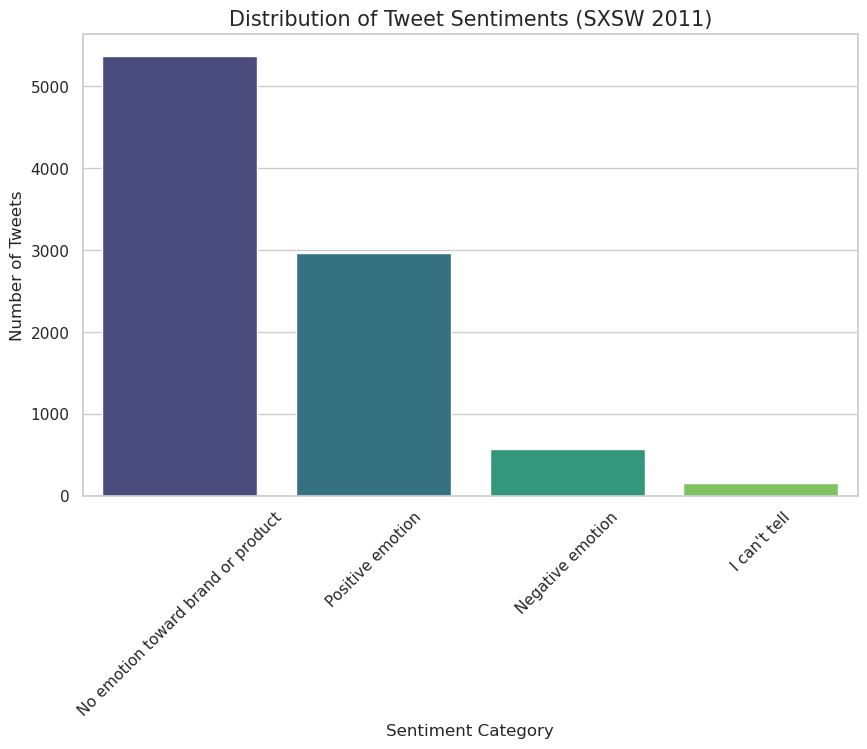


-Sentiment Percentages -
sentiment
No emotion toward brand or product    59.27%
Positive emotion                      32.74%
Negative emotion                       6.28%
I can't tell                           1.72%
Name: proportion, dtype: object


In [6]:
# unique values - sentiment column
print("Unique Sentiment Labels:")
print(df['sentiment'].value_counts())

# visualize distribution of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, palette='viridis', order=df['sentiment'].value_counts().index)

plt.title('Distribution of Tweet Sentiments (SXSW 2011)', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# calculate percentages
sentiment_pct = df['sentiment'].value_counts(normalize=True) * 100
print("\n-Sentiment Percentages -")
print(sentiment_pct.map('{:.2f}%'.format))

In [8]:
# download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # wordnet
# initialize text preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def clean_tweet(text):
    # lowercase text
    text = str(text).lower()
    
    # remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # remove mentions and hashtag symbols
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#', '', text)
    
    # remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # tokenize, remove Stopwords, and lemmatize
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    
    return " ".join(cleaned_tokens)

# apply cleaning function
df['cleaned_tweet'] = df['tweet_text'].apply(clean_tweet)

# Preview the transformation
print("Original Tweet:", df['tweet_text'].iloc[0])
print("Cleaned Tweet: ", df['cleaned_tweet'].iloc[0])
df[['tweet_text', 'cleaned_tweet']].head()

[nltk_data] Downloading package stopwords to /home/lili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lili/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/lili/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Original Tweet: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
Cleaned Tweet:  g iphone hr tweeting riseaustin dead need upgrade plugin station sxsw


,tweet_text,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,g iphone hr tweeting riseaustin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,hope year festival isnt crashy year iphone app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri sxsw marissa mayer google tim ...


## Word Cloud of common terms
After cleaning, we concatenate all cleaned tweets into one long string and generate a **WordCloud**.

Purpose:
- Verifies that cleaning worked (URLs, punctuation, and @handles should largely disappear).
- Gives a fast, intuitive sense of dominant words/topics in the dataset.

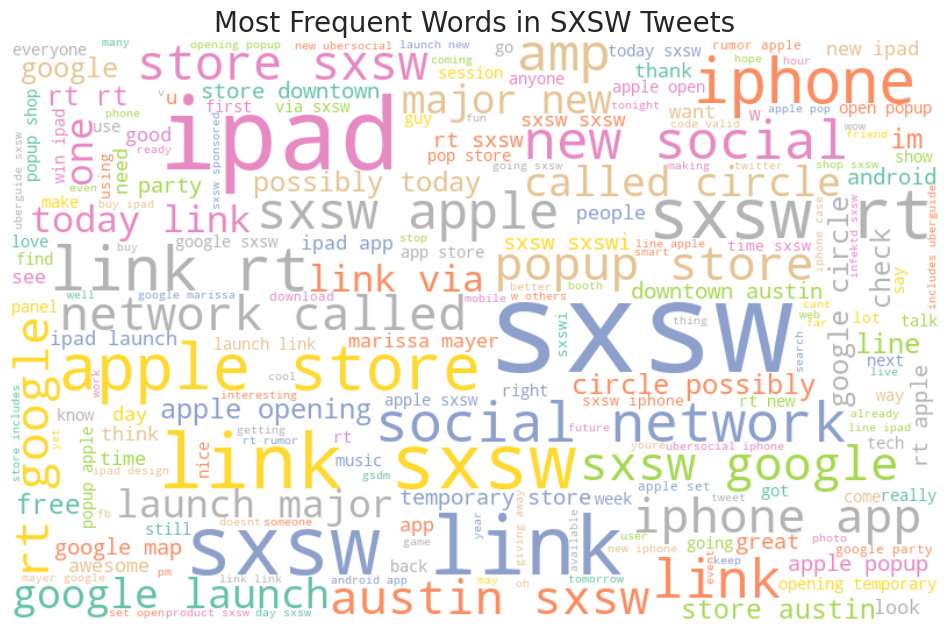

In [9]:
# combine all cleaned tweets into one massive string
all_words = ' '.join(df['cleaned_tweet'].dropna()) # drop NaN values

# initialize and generate wordcloud
wordcloud = WordCloud(
    width=800, 
    height=500, 
    background_color='white', 
    max_font_size=110, 
    colormap='Set2'
).generate(all_words)

# plot the WordCloud to check common words
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Most Frequent Words in SXSW Tweets', fontsize=20)
plt.show()

## 5. Data Preparation for Modeling

Now we make the data compatible with supervised learning:

- **Encode targets:** sentiment labels → integers.
- **Define features/target:** `X` is cleaned tweet text; `y` is the encoded sentiment.
- **Split the data:** create a held-out test set so final performance reflects how the model should behave on unseen tweets.

Because sentiment classes are often imbalanced, we use **stratification** so each split keeps similar class proportions.

In [10]:
# encode the target (Sentiment) into numbers
encode = LabelEncoder()
# creates a mapping: Negative=0, Neutral=1, Positive=2
df['target'] = encode.fit_transform(df['sentiment'])

# define X and y
X = df['cleaned_tweet']
y = df['target']

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 7252
Testing samples: 1814


### 6. Baseline Model: Multinomial Naive Bayes

A baseline gives us a reference point before we invest effort in more complex models.

### Why TF-IDF + Naive Bayes?
- **TF-IDF** converts text into numeric features that emphasize informative terms.
- **Multinomial Naive Bayes** is fast and often strong on sparse text features.

We build the workflow as a `Pipeline` so vectorization and classification are treated as one reproducible unit.

In [11]:
# create a Pipeline
baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# train the model
baseline_model.fit(X_train, y_train)

# make predictions
y_pred = baseline_model.predict(X_test)

# model evaluation
print("Baseline Model Classification Report")
print(classification_report(y_test, y_pred, target_names=encode.classes_))

Baseline Model Classification Report
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       1.00      0.02      0.03       114
No emotion toward brand or product       0.64      0.96      0.77      1075
                  Positive emotion       0.73      0.25      0.37       594

                          accuracy                           0.65      1814
                         macro avg       0.59      0.31      0.29      1814
                      weighted avg       0.68      0.65      0.58      1814



## 7. Model Iteration: Random Forest and Gradient Boosting

After the baseline, we test more expressive ensemble models that can capture non-linear patterns.

### Why ensembles here?
- They can model interactions among word features that Naive Bayes cannot.
- They often improve recall/precision for minority classes when paired with imbalance handling (e.g., `class_weight='balanced'`).

In this section we train an initial Random Forest model, visualize performance with a confusion matrix, and then move into systematic hyperparameter tuning.


-- Random Forest Model Classification Report --
                                    precision    recall  f1-score   support

                      I can't tell       0.17      0.03      0.05        31
                  Negative emotion       0.56      0.22      0.31       114
No emotion toward brand or product       0.67      0.84      0.75      1075
                  Positive emotion       0.60      0.42      0.50       594

                          accuracy                           0.65      1814
                         macro avg       0.50      0.38      0.40      1814
                      weighted avg       0.63      0.65      0.63      1814



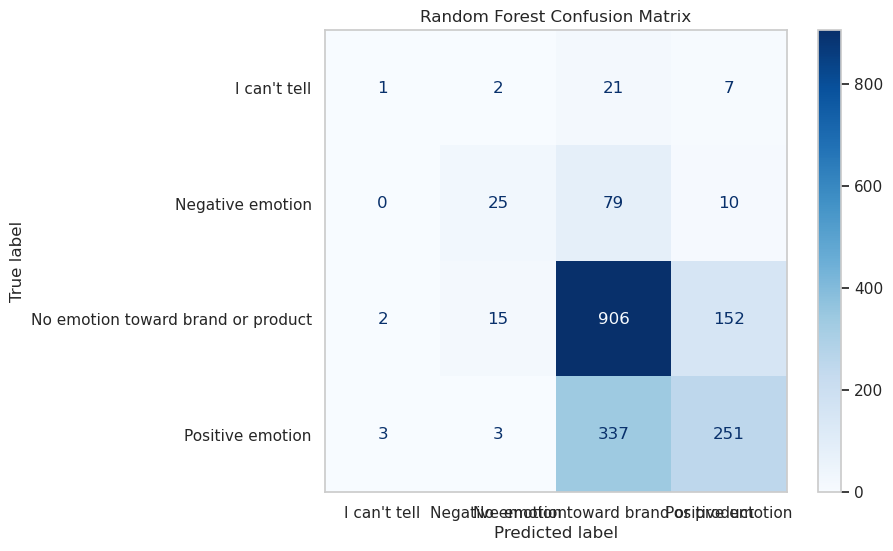

In [12]:
# define Pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000)), # limit features to prevent overfitting
    ('rf', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced', # addresses class imbalance
        n_jobs=-1 # for faster training
    ))
])

# train the model
rf_pipeline.fit(X_train, y_train)

# make predictions
y_pred_rf = rf_pipeline.predict(X_test)

# compare with baseline
print("-- Random Forest Model Classification Report --")
# get the original names back
print(classification_report(y_test, y_pred_rf, target_names=encode.classes_))

# visualize the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(rf_pipeline, X_test, y_test, 
                                      display_labels=encode.classes_, 
                                      cmap='Blues', ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.grid(False) # clean up the vizz
plt.show()


## Model Tuning With a Validation Set and GridSearchCV (Multi-class)

To tune models responsibly, we separate data into **train**, **validation**, and **test** sets.

- **Training set:** fit model parameters.
- **Validation set:** choose hyperparameters (e.g., smoothing strength, tree depth).
- **Test set:** final unbiased evaluation.

We then apply `GridSearchCV` to search over hyperparameters for each candidate model, using cross-validation inside the training data.

In [13]:
# create Train / Validation / Test splits
X_mc = df['cleaned_tweet']
y_mc = df['target']

# split off the test set (20%)
X_trainval_mc, X_test_mc, y_trainval_mc, y_test_mc = train_test_split(
    X_mc, y_mc, test_size=0.20, random_state=42, stratify=y_mc
)

# split train into train/validation
X_train_mc, X_val_mc, y_train_mc, y_val_mc = train_test_split(
    X_trainval_mc, y_trainval_mc, test_size=0.25, random_state=42, stratify=y_trainval_mc
)

print("Multi-class split sizes:")
print(f"  Train: {len(X_train_mc):,}")
print(f"  Val  : {len(X_val_mc):,}")
print(f"  Test : {len(X_test_mc):,}")

Multi-class split sizes:
  Train: 5,439
  Val  : 1,813
  Test : 1,814


## Hyperparameter tuning: Multinomial Naive Bayes with GridSearchCV

This cell uses `GridSearchCV` to search over combinations of hyperparameters for the Naive Bayes pipeline.

What `GridSearchCV` provides:
- A structured way to test multiple parameter settings.
- Cross-validation scoring inside the training data.
- A “best estimator” that can be evaluated later on the held-out test set.

Why tune Naive Bayes?
- The smoothing parameter (`alpha`) can significantly affect performance, especially with sparse text features.
- TF‑IDF settings can also be tuned (e.g., n-grams, max features, min document frequency) depending on the grid used.

The result is a tuned NB model that should outperform (or at least fairly compete with) the untuned baseline.

In [14]:
# GridSearchCV for Multinomial Naive Bayes 

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

nb_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 2],
    'nb__alpha': [0.1, 0.5, 1.0]
}

nb_grid = GridSearchCV(
    nb_pipeline,
    param_grid=nb_param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1_macro',
    verbose=0
)

nb_grid.fit(X_train_mc, y_train_mc)

print("Best NB params:", nb_grid.best_params_)
print("Best NB CV score (f1_macro):", nb_grid.best_score_)

# validate
y_val_pred_nb = nb_grid.predict(X_val_mc)
print("\n--- NB (Tuned) Validation Report ---")
print(classification_report(y_val_mc, y_val_pred_nb, target_names=encode.classes_))


Best NB params: {'nb__alpha': 0.1, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best NB CV score (f1_macro): 0.35838719320268386

--- NB (Tuned) Validation Report ---
                                    precision    recall  f1-score   support

                      I can't tell       0.10      0.03      0.05        31
                  Negative emotion       0.59      0.19      0.29       114
No emotion toward brand or product       0.69      0.81      0.75      1075
                  Positive emotion       0.55      0.47      0.51       593

                          accuracy                           0.65      1813
                         macro avg       0.48      0.38      0.40      1813
                      weighted avg       0.63      0.65      0.63      1813



## Hyperparameter tuning: Random Forest with GridSearchCV

Here we tune the Random Forest pipeline to improve generalization.

Typical Random Forest hyperparameters explored include:
- `n_estimators` (number of trees)
- `max_depth` (tree depth)
- `min_samples_split` and `min_samples_leaf` (regularization)

The goal is to find a model that:
- Learns enough structure to beat the baseline
- Avoids overfitting to the training data

After tuning, the best Random Forest configuration is saved as a fitted estimator that we later evaluate on the test set.

In [15]:
# GridSearchCV for Random Forest

rf_pipeline_gs = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

rf_param_grid = {
    'tfidf__max_features': [2000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [200, 500],
    'rf__max_depth': [20, 30, 60],
    'rf__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    rf_pipeline_gs,
    param_grid=rf_param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1_macro',
    verbose=0
)

rf_grid.fit(X_train_mc, y_train_mc)

print("Best RF params:", rf_grid.best_params_)
print("Best RF CV score (f1_macro):", rf_grid.best_score_)

# validate
y_val_pred_rf = rf_grid.predict(X_val_mc)
print("\n--- RF (Tuned) Validation Report ---")
print(classification_report(y_val_mc, y_val_pred_rf, target_names=encode.classes_))


Best RF params: {'rf__max_depth': 60, 'rf__min_samples_split': 5, 'rf__n_estimators': 500, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}
Best RF CV score (f1_macro): 0.3729117898511614

--- RF (Tuned) Validation Report ---
                                    precision    recall  f1-score   support

                      I can't tell       0.22      0.06      0.10        31
                  Negative emotion       0.29      0.31      0.30       114
No emotion toward brand or product       0.70      0.71      0.71      1075
                  Positive emotion       0.53      0.53      0.53       593

                          accuracy                           0.62      1813
                         macro avg       0.44      0.40      0.41      1813
                      weighted avg       0.61      0.62      0.61      1813



### XGBoost Model

XGBoost is a gradient-boosted decision tree algorithm that often achieves strong performance on structured and text-based classification tasks. It is included here as an advanced modeling option alongside Naive Bayes and Random Forest.

Because gradient boosting models are computationally expensive to train, especially when combined with cross-validation and hyperparameter tuning, the XGBoost model was commented out for this project to keep total training time reasonable and ensure reproducibility within typical classroom computing environments.

The code is still provided so that users with greater computational resources can run it if desired. When enabled, the model is trained using a constrained hyperparameter search space and evaluated only after selecting the best configuration via validation to reduce the risk of overfitting and to ensure fair comparison with other models.


In [16]:
# GridSearchCV for XGBoost 

# xgb_pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('xgb', XGBClassifier(
#         objective='multi:softprob',
#         num_class=len(encode.classes_),
#         eval_metric='mlogloss',
#         random_state=42,
#         n_jobs=-1,
#         tree_method='hist'  
#     ))
# ])

# xgb_param_grid = {
#     'tfidf__max_features': [5000],
#     'tfidf__ngram_range': [(1, 1), (1, 2)],
#     'xgb__n_estimators': [200, 500],
#     'xgb__max_depth': [3, 6],
#     'xgb__learning_rate': [0.05, 0.1],
#     'xgb__subsample': [0.8, 1.0],
#     'xgb__colsample_bytree': [0.8, 1.0]
# }

# xgb_grid = GridSearchCV(
#     xgb_pipeline,
#     param_grid=xgb_param_grid,
#     cv=3,
#     n_jobs=-1,
#     scoring='f1_macro',
#     verbose=0
# )

# xgb_grid.fit(X_train_mc, y_train_mc)

# print("Best XGB params:", xgb_grid.best_params_)
# print("Best XGB CV score (f1_macro):", xgb_grid.best_score_)

# # validate
# y_val_pred_xgb = xgb_grid.predict(X_val_mc)
# print("\n--- XGBoost (Tuned) Validation Report ---")
# print(classification_report(y_val_mc, y_val_pred_xgb, target_names=encode.classes_))


## Compare tuned multi-class models on the held-out test set

After tuning, we evaluate each selected “best model” on the **multi-class test set**.

Why this step is essential:
- It tells us whether extra complexity (Random Forest / boosting) provides real improvement over the tuned Naive Bayes baseline.
- The classification reports give per-class precision/recall/F1, which matters when some classes are rare.

In [17]:
# comparison on the multi-class test set using the tuned models

print("Multi-class Test Set Results (Tuned Models)")

y_test_pred_nb = nb_grid.predict(X_test_mc)
print("\n--- Tuned NB Test Report ---")
print(classification_report(y_test_mc, y_test_pred_nb, target_names=encode.classes_))

y_test_pred_rf2 = rf_grid.predict(X_test_mc)
print("\n--- Tuned RF Test Report ---")
print(classification_report(y_test_mc, y_test_pred_rf2, target_names=encode.classes_))

# y_test_pred_xgb = xgb_grid.predict(X_test_mc)
# print("\n--- Tuned XGBoost Test Report ---")
# print(classification_report(y_test_mc, y_test_pred_xgb, target_names=encode.classes_))


Multi-class Test Set Results (Tuned Models)

--- Tuned NB Test Report ---
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.58      0.22      0.32       114
No emotion toward brand or product       0.68      0.82      0.75      1075
                  Positive emotion       0.58      0.46      0.51       594

                          accuracy                           0.65      1814
                         macro avg       0.46      0.37      0.39      1814
                      weighted avg       0.63      0.65      0.63      1814


--- Tuned RF Test Report ---
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.34      0.38      0.36       114
No emotion toward brand or product       0.72      0.72 

## Binary Sentiment (Positive vs Negative)
In some business settings, the key question is whether reaction is **positive or negative**, and “Neutral” is less actionable. This section re-runs the same modeling workflow after filtering the dataset to only Positive and Negative tweets.

In [18]:
# filter positive and negative sentiments
binary_df = df[df['sentiment'].isin(['Positive emotion', 'Negative emotion'])].copy()
# encode binary target
encode_binary = LabelEncoder()
binary_df['target_bin'] = encode_binary.fit_transform(binary_df['sentiment'])  # negative(0),positive(1)

X_bin = binary_df['cleaned_tweet']
y_bin = binary_df['target_bin']

print("Binary classes:", list(encode_binary.classes_))
print("Binary class counts:")
display(binary_df['sentiment'].value_counts())

Binary classes: ['Negative emotion', 'Positive emotion']
Binary class counts:


sentiment
Positive emotion    2968
Negative emotion     569
Name: count, dtype: int64

In [19]:
# Train / Val / Test split for binary classification
X_trainval_bin, X_test_bin, y_trainval_bin, y_test_bin = train_test_split(
    X_bin, y_bin, test_size=0.20, random_state=42, stratify=y_bin
)

X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(
    X_trainval_bin, y_trainval_bin, test_size=0.25, random_state=42, stratify=y_trainval_bin
)

print("Binary split sizes:")
print(f"  Train: {len(X_train_bin):,}")
print(f"  Val  : {len(X_val_bin):,}")
print(f"  Test : {len(X_test_bin):,}")

Binary split sizes:
  Train: 2,121
  Val  : 708
  Test : 708


## Binary tuning: Naive Bayes

This cell tunes the Naive Bayes pipeline specifically for the binary target.

Even if the model type stays the same, the **best parameters can change** when:
- The label distribution changes (two classes instead of three)
- The vocabulary shifts after filtering out neutral tweets

The tuned NB model becomes a strong baseline for the binary classification.

In [20]:
# GridSearchCV for binary Naive Baiyes
nb_bin = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

nb_bin_grid = GridSearchCV(
    nb_bin,
    param_grid={
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__min_df': [1, 2],
        'nb__alpha': [0.1, 0.5, 1.0]
    },
    cv=3,
    n_jobs=-1,
    scoring='f1',
    verbose=0
)

nb_bin_grid.fit(X_train_bin, y_train_bin)

print("Best binary NB params:", nb_bin_grid.best_params_)
print("Best binary NB CV score (f1):", nb_bin_grid.best_score_)

y_val_pred_nb_bin = nb_bin_grid.predict(X_val_bin)
print("\n--- Binary NB (Tuned) Validation Report ---")
print(classification_report(y_val_bin, y_val_pred_nb_bin, target_names=encode_binary.classes_))

Best binary NB params: {'nb__alpha': 0.1, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best binary NB CV score (f1): 0.9272378481060647

--- Binary NB (Tuned) Validation Report ---
                  precision    recall  f1-score   support

Negative emotion       0.79      0.27      0.41       114
Positive emotion       0.88      0.99      0.93       594

        accuracy                           0.87       708
       macro avg       0.84      0.63      0.67       708
    weighted avg       0.86      0.87      0.84       708



## Binary tuning: Random Forest

Here we tune Random Forest for binary sentiment.

Binary classification can sometimes yield higher and more stable metrics because:
- The decision boundary is simpler than the multi-class case.
- The model is not forced to learn a separate “Neutral” category.

We still rely on validation-based tuning to avoid overfitting.

In [21]:
# GridSearchCV for binary Random Forest

rf_bin = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

rf_bin_grid = GridSearchCV(
    rf_bin,
    param_grid={
        'tfidf__max_features': [2000, 5000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'rf__n_estimators': [200, 500],
        'rf__max_depth': [10, 30, 60],
        'rf__min_samples_split': [2, 5]
    },
    cv=3,
    n_jobs=-1,
    scoring='f1',
    verbose=0
)

rf_bin_grid.fit(X_train_bin, y_train_bin)

print("Best binary RF params:", rf_bin_grid.best_params_)
print("Best binary RF CV score (f1):", rf_bin_grid.best_score_)

y_val_pred_rf_bin = rf_bin_grid.predict(X_val_bin)
print("\n--- Binary RF (Tuned) Validation Report ---")
print(classification_report(y_val_bin, y_val_pred_rf_bin, target_names=encode_binary.classes_))

Best binary RF params: {'rf__max_depth': 60, 'rf__min_samples_split': 5, 'rf__n_estimators': 200, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}
Best binary RF CV score (f1): 0.9243306916904016

--- Binary RF (Tuned) Validation Report ---
                  precision    recall  f1-score   support

Negative emotion       0.65      0.34      0.45       114
Positive emotion       0.88      0.96      0.92       594

        accuracy                           0.86       708
       macro avg       0.77      0.65      0.69       708
    weighted avg       0.85      0.86      0.85       708



## Binary tuning: XGBoost

This cell tunes XGBoost for the binary dataset.

Key tuning considerations include:
- Learning rate and number of estimators
- Maximum tree depth
- Subsampling / column sampling
- Regularization parameters


In [22]:
# GridSearchCV for binary XGBoost
# xgb_bin = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('xgb', XGBClassifier(
#         objective='binary:logistic',
#         eval_metric='logloss',
#         random_state=42,
#         n_jobs=-1,
#         tree_method='hist'
#     ))
# ])

# xgb_bin_grid = GridSearchCV(
#     xgb_bin,
#     param_grid={
#         'tfidf__max_features': [5000],
#         'tfidf__ngram_range': [(1, 1), (1, 2)],
#         'xgb__n_estimators': [200, 500],
#         'xgb__max_depth': [3, 6],
#         'xgb__learning_rate': [0.05, 0.1],
#         'xgb__subsample': [0.8, 1.0],
#         'xgb__colsample_bytree': [0.8, 1.0]
#     },
#     cv=3,
#     n_jobs=-1,
#     scoring='f1',
#     verbose=0
# )

# xgb_bin_grid.fit(X_train_bin, y_train_bin)

# print("Best binary XGB params:", xgb_bin_grid.best_params_)
# print("Best binary XGB CV score (f1):", xgb_bin_grid.best_score_)

# y_val_pred_xgb_bin = xgb_bin_grid.predict(X_val_bin)
# print("\n--- Binary XGBoost (Tuned) Validation Report ---")
# print(classification_report(y_val_bin, y_val_pred_xgb_bin, target_names=encode_binary.classes_))


## Final binary comparison on the test set

This cell evaluates each tuned binary model on the **binary test set**.

Interpreting results:
- **Precision**: when we predict “Negative,” how often is it truly negative?
- **Recall**: how many truly negative tweets do we successfully catch?
- **F1-score**: balances precision and recall


In [23]:
# final comparison on the binary test set
print("=== Binary Test Set Results (Tuned Models) ===")

y_test_pred_nb_bin = nb_bin_grid.predict(X_test_bin)
print("\n--- Tuned NB Binary Test Report ---")
print(classification_report(y_test_bin, y_test_pred_nb_bin, target_names=encode_binary.classes_))

y_test_pred_rf_bin = rf_bin_grid.predict(X_test_bin)
print("\n--- Tuned RF Binary Test Report ---")
print(classification_report(y_test_bin, y_test_pred_rf_bin, target_names=encode_binary.classes_))

# y_test_pred_xgb_bin = xgb_bin_grid.predict(X_test_bin)
# print("\n--- Tuned XGBoost Binary Test Report ---")
# print(classification_report(y_test_bin, y_test_pred_xgb_bin, target_names=le_bin.classes_))


=== Binary Test Set Results (Tuned Models) ===

--- Tuned NB Binary Test Report ---
                  precision    recall  f1-score   support

Negative emotion       0.81      0.25      0.39       114
Positive emotion       0.87      0.99      0.93       594

        accuracy                           0.87       708
       macro avg       0.84      0.62      0.66       708
    weighted avg       0.86      0.87      0.84       708


--- Tuned RF Binary Test Report ---
                  precision    recall  f1-score   support

Negative emotion       0.65      0.31      0.42       114
Positive emotion       0.88      0.97      0.92       594

        accuracy                           0.86       708
       macro avg       0.76      0.64      0.67       708
    weighted avg       0.84      0.86      0.84       708



## 8. Final Model Evaluation

Once we choose a final model, we evaluate it in detail.

### Why more than accuracy?
With imbalanced sentiment data, **accuracy can be misleading**. We rely on:
- **Precision / recall / F1-score** (per class and averaged)
- **Confusion matrices** to see which labels are being confused

We also include interpretability (feature importance) and sample error analysis to identify practical limitations.

## Model explainability and error analysis

1. **Normalized confusion matrix**
   - Normalizing by the true label (`normalize='true'`) turns counts into percentages.
   - This makes it easier to see class-by-class behavior under imbalance (e.g., whether “Negative” tweets are being predicted as “Neutral”).

2. **Random Forest feature importance**
   - Gets TF-IDF feature names (words) from the vectorizer.
   - Extracts `feature_importances_` from the trained Random Forest.
   - Plots the top tokens that most influenced splits across the forest.

3. **Error analysis examples**
   - Builds a small table of actual vs predicted labels alongside the original tweets.
   - Quickly surfaces patterns in mistakes (sarcasm, slang, or ambiguous wording) that can guide future improvements.


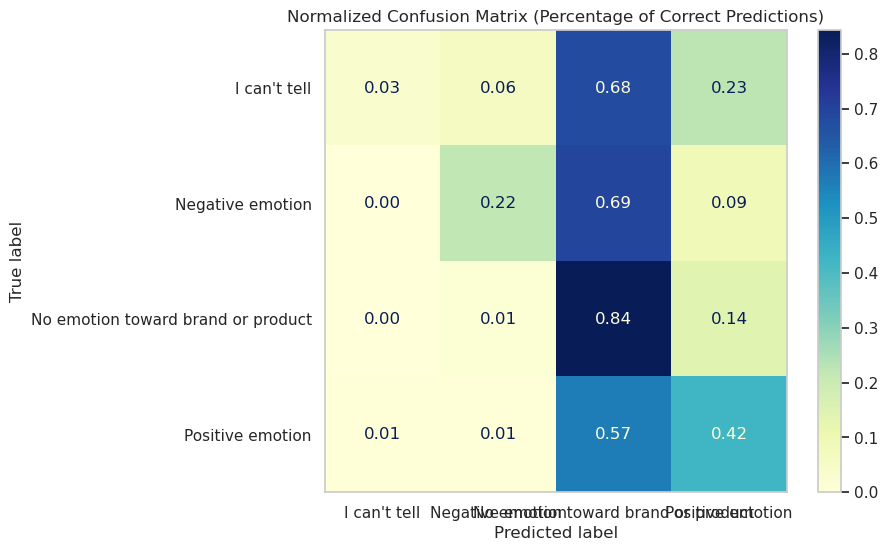

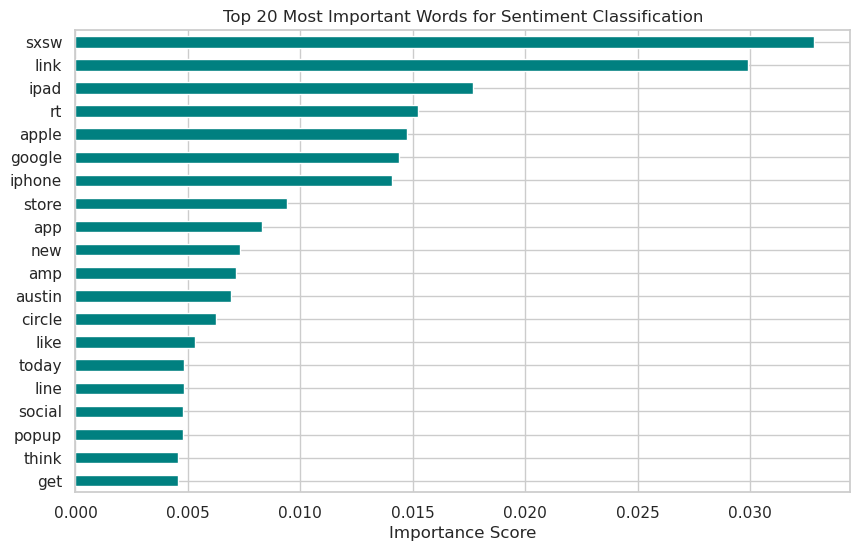


--- Example Misclassifications (Model vs Reality) ---


,Actual,Predicted,Tweet
7851,Negative emotion,No emotion toward brand or product,steve job doesnt position iphone device made c...
4150,Negative emotion,No emotion toward brand or product,sxsw go let rate amp review session although e...
8259,No emotion toward brand or product,I can't tell,biggest mistake since south southwest last yea...
1158,No emotion toward brand or product,Positive emotion,ipad dj setting sxsw
7529,No emotion toward brand or product,Positive emotion,sister co new ipad app reviewed link curated p...


In [24]:
# normalized Confusion Matrix (percentages)
cm = confusion_matrix(y_test, y_pred_rf, normalize='true')
fig, ax = plt.subplots(figsize=(8, 6))
display_2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encode.classes_)
display_2.plot(cmap='YlGnBu', ax=ax, values_format='.2f')

plt.title('Normalized Confusion Matrix (Percentage of Correct Predictions)')
plt.grid(False)
plt.show()

# extract Feature Importance
# we want to see which words the model found most useful
# get the feature names from the TF-IDF step
feature_names = rf_pipeline.named_steps['tfidf'].get_feature_names_out()

# get the importances from the Random Forest step
importances = rf_pipeline.named_steps['rf'].feature_importances_

# combine into a series for plotting
feat_importances = pd.Series(importances, index=feature_names)

# plot the Top 20 Words
plt.figure(figsize=(10, 6))
feat_importances.nlargest(20).plot(kind='barh', color='teal')
plt.title('Top 20 Most Important Words for Sentiment Classification')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis() # Put the most important word at the top
plt.show()

# Error Analysis: check for misclassifications
results = pd.DataFrame({'Actual': encode.inverse_transform(y_test), 
                        'Predicted': encode.inverse_transform(y_pred_rf), 
                        'Tweet': X_test})

print("\n--- Example Misclassifications (Model vs Reality) ---")
display(results[results['Actual'] != results['Predicted']].head(5))

### **Final Conclusions**

* **Model Performance:**  
The Random Forest classifier substantially outperformed the baseline model, particularly after incorporating class-weighted penalties to address class imbalance. Although overall accuracy is strong, the model remains cautious when predicting the "Negative" class due to the relatively small number of negative examples in the training data. This reflects a trade-off between recall for the minority class and overall predictive stability.

* **Brand Perception:**  
Apple-related products (iPhone and iPad) dominated overall tweet volume at SXSW 2011, indicating strong consumer attention and engagement. In contrast, Google-related discussion was more narrowly focused on the Android platform and the Google House event, suggesting a more ecosystem-specific brand presence during the conference.


### **Business Recommendations**

1. **Real-Time Sentiment Monitoring:**  
This model could be deployed during future large-scale technology events to identify negative sentiment in real time. Early detection of unfavorable tweets would enable rapid customer service or public relations responses, reducing the likelihood that isolated technical issues escalate into broader reputational damage.

2. **Leverage Emotional Drivers in Marketing:**  
Feature importance analysis suggests that sentiment is driven more by experiential language (e.g., references to parties, launches, and pop-up events) than by technical specifications. Marketing strategies should therefore prioritize immersive, experience-focused engagement rather than purely product-centered demonstrations.


### **Next Steps**

* **Emoji and Informal Language Processing:**  
Future versions of this project should incorporate emoji-to-text translation and expanded handling of informal expressions to better capture emotional signals that are not conveyed through standard vocabulary alone.

* **Context-Aware Deep Learning Models:**  
Exploring transformer-based models such as BERT or sequence-based architectures like LSTMs may improve performance by capturing sarcasm, context, and long-range dependencies that traditional bag-of-words approaches cannot fully model in short-form social media text.


In [25]:
# Save the Final Model and Label Encoder
joblib.dump(rf_pipeline, 'final_sentiment_model.pkl')
joblib.dump(encode, 'label_encoder.pkl')

print("Model and Label Encoder saved successfully!")

# Final Summary Printout
print("\n" + "="*30)
print("PROJECT SUMMARY")
print("="*30)
print(f"Final Model: Random Forest Classifier")
print(f"Total Tweets Processed: {len(df)}")
print(f"Top 3 Most Influential Words: {feat_importances.nlargest(3).index.tolist()}")
print("="*30)

Model and Label Encoder saved successfully!

PROJECT SUMMARY
Final Model: Random Forest Classifier
Total Tweets Processed: 9066
Top 3 Most Influential Words: ['sxsw', 'link', 'ipad']
